# Model 1-Age and Gender Detection.

## Ayushi Singh
## 200968244 

In [1]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

In [2]:
#C:\Users\Asus\dl_project\project3\modelNweight
import os
os.chdir(r'E:\semester 5\Deep Learning\dl_project\project2\models')

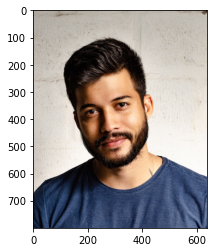

In [3]:
image="image.jpg"
img = mpimg.imread('E:\semester 5\Deep Learning\dl_project\project2\models\image.jpg')
plt.imshow(img)
#image1="/content/gdrive/MyDrive/Project_dl_2/project3/required files/image1.jpg"
#image2="/content/gdrive/MyDrive/Project_dl_2/project3/required files/image2.jpg"

In [4]:
image1="image1.jpg"
img1 = mpimg.imread('E:\semester 5\Deep Learning\dl_project\project2\models\image1.jpg')

In [5]:
# Downloading pretrained data and unzipping it
#!gdown https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
# https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
#!unzip modelNweight.zip

In [6]:
#pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [16]:
# Import required modules
import cv2 as cv
import math
import time
from matplotlib import pyplot as plt
#use plt.imshow(image)

##function to take files from opencv_face_detector and then detect faces.
## here conf_threshold is the confidence threshold which tells us that the min confidence of face detection should be 70%.
def getFaceBox(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    #fixing frame width and height.
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    ##blob is a image processing funtion of opencv which performs the following function:1.Mean subtraction 2.Scaling 3.And optionally channel swapping.
    ## Also it converts the image to 4-D array.
    ##here scalefactor(scaledown the video)=1.0,size(that CNN expects)=300*300,mean(of R,G,B for mean substraction i.e removing some colors)-(104,117,123),
    ##swapRB=true(as open cv expects image to be in BGR rather than RGB ),crop(videoframe)=false.
    blob = cv.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()##will give the preprocessed image as output.
    bboxes = []##boxes or frames for detected face.

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]  ## extracting element of 4-D array.
        if confidence > conf_threshold:
            ## drawing frame whoose 4 sides are x1,x2,y1,y2.
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes



## Loading the pre-trained caffemodels.
faceProto = "opencv_face_detector.pbtxt.txt"
faceModel = "opencv_face_detector_uint8.pb"

ageProto = "age_deploy.prototxt.txt"
ageModel = "age_net.caffemodel"

genderProto = "gender_deploy.prototxt.txt"
genderModel = "gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

# Load network
ageNet = cv.dnn.readNet(ageModel, ageProto)
genderNet = cv.dnn.readNet(genderModel, genderProto)
faceNet = cv.dnn.readNet(faceModel, faceProto)

padding = 20


def age_gender_detector(frame):
    # Read frame
    t = time.time()
    frameFace, bboxes = getFaceBox(faceNet, frame)
    for bbox in bboxes:
        # print(bbox)
        face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]
        ##preprocessing- again using blob to make any image/video inputed,similar to the images on which the pretrained models were trained.
        blob = cv.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]

        label = "{},{}".format(gender, age)
        cv.putText(frameFace, label, (bbox[0], bbox[1]-10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv.LINE_AA)
    return frameFace

In [ ]:
## detect age and gender from videos.
faceBoxes=[]
video=cv.VideoCapture(0)
padding=20
while cv.waitKey(1)<0:
    hasFrame,frame=video.read()
    if not hasFrame:
        cv.waitKey()
        break
        
    resultImg,faceBoxes=getFaceBox(faceNet,frame)
    
    if not faceBoxes:
        print("No face detected")
    
    for faceBox in faceBoxes:
        face=frame[max(0,faceBox[1]-padding):min(faceBox[3]+padding,frame.shape[0]-1),max(0,faceBox[0]-padding):min(faceBox[2]+padding, frame.shape[1]-1)]
        blob=cv2.dnn.blobFromImage(face,1.0,(227,227),[124.96,115.97,106.13],swapRB=True,crop=False)
        genderNet.setInput(blob)
        genderPreds=genderNet.forward()
        gender=genderList[genderPreds[0].argmax()]
        
        ageNet.setInput(blob)
        agePreds=ageNet.forward()
        age=ageList[agePreds[0].argmax()]
        cv.putText(resultImg,f'{gender},{age}',(faceBox[0],faceBox[1]-10),cv.FONT_HERSHEY_SIMPLEX,0.8,(0,255,255),2,cv.LINE_AA)
        cv.imshow("Detecting age and Gender",resultImg)
        
        
        if cv.waitKey(1) & 0xFF == ord('q'):
            break

cv.destroyAllWindows()
        

In [ ]:
#cap.release()
#out.release()

#if not (cap.isOpened()):
            print("Could not open video device")

In [ ]:
#input = cv.imread(image2)
#output = age_gender_detector(input)
#cv2_imshow(output)

In [20]:
## Upload any video named video.mp4 or to use live video use the code on local system with "cap = cv2.VideoCapture(0)".
import cv2
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
frame_height, frame_width, _ = frame.shape
out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
print("Processing Video...")
while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    out.release()
    break
  output = age_gender_detector(frame)
  out.write(output)
out.release()
print("Done processing video")

Processing Video...
Done processing video
